In [1]:
!pip install kagglehub==0.3.3


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import kagglehub
import os
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.metrics import confusion_matrix
import itertools

/Users/lillianho/CSE_151A_Project/cse151a-trash/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download latest version of kaggle dataset
path = kagglehub.dataset_download("alistairking/recyclable-and-household-waste-classification")

print("Path to dataset files:", path)

Path to dataset files: /Users/lillianho/.cache/kagglehub/datasets/alistairking/recyclable-and-household-waste-classification/versions/1


In [3]:
path

'/Users/lillianho/.cache/kagglehub/datasets/alistairking/recyclable-and-household-waste-classification/versions/1'

In [4]:
!ls /root/.cache/kagglehub/datasets/alistairking/recyclable-and-household-waste-classification/versions/1

ls: /root/.cache/kagglehub/datasets/alistairking/recyclable-and-household-waste-classification/versions/1: No such file or directory


In [5]:
!rm /root/.cache/kagglehub/datasets/alistairking/recyclable-and-household-waste-classification/versions/1/README.txt

rm: /root/.cache/kagglehub/datasets/alistairking/recyclable-and-household-waste-classification/versions/1/README.txt: No such file or directory


In [6]:
!ls /root/.cache/kagglehub/datasets/alistairking/recyclable-and-household-waste-classification/versions/1

ls: /root/.cache/kagglehub/datasets/alistairking/recyclable-and-household-waste-classification/versions/1: No such file or directory


In [7]:
!ls /root/.cache/kagglehub/datasets/alistairking/recyclable-and-household-waste-classification/versions/1/images/images

ls: /root/.cache/kagglehub/datasets/alistairking/recyclable-and-household-waste-classification/versions/1/images/images: No such file or directory


# Data Exploration 

The following code blocks loads and organizes images by category and setting (either "default" or "real_world"). The variable `class_path` defines the main directory containing the images. The `classes` list retrieves the category names within this path. Three lists—`image_paths`, `labels`, and `d_r` are initialized to store the image paths, their respective categories/classes, and the setting type. A nested loop iterates over each category and subfolder ("default" and "real_world"), appending the image paths, category labels, and setting identifiers to these lists. 

In [8]:
# Get image paths and create lists to populate later
class_path = path + '/images' + '/images'
classes = os.listdir(class_path)
image_paths = []
labels = [] # Trash category associated with each image
d_r = [] # default (studio/standard) vs real world img

print(classes)

['disposable_plastic_cutlery', 'food_waste', 'office_paper', 'glass_food_jars', 'aluminum_soda_cans', 'magazines', 'clothing', 'plastic_shopping_bags', 'plastic_soda_bottles', 'styrofoam_food_containers', 'aerosol_cans', 'aluminum_food_cans', 'newspaper', 'eggshells', 'glass_cosmetic_containers', 'paper_cups', 'plastic_water_bottles', 'coffee_grounds', 'steel_food_cans', 'plastic_cup_lids', 'cardboard_packaging', 'cardboard_boxes', 'plastic_straws', 'styrofoam_cups', 'glass_beverage_bottles', 'shoes', 'plastic_trash_bags', 'tea_bags', 'plastic_food_containers', 'plastic_detergent_bottles']


In [9]:
# Access image folders and populate lists with needed data
for i, label in enumerate(classes):
    class_dir = os.path.join(class_path, label)
    for subfolder in ['default', 'real_world']:
        subfolder_dir = os.path.join(class_dir, subfolder)
        image_names = os.listdir(subfolder_dir)
        
        for image_name in image_names:
            d_r.append(subfolder)
            image_paths.append(os.path.join(subfolder_dir, image_name))
            labels.append(label)

In [10]:
# Get image sizes of every image and populate list
image_sizes = []
for image_path in image_paths:
    im = Image.open(image_path)
    image_sizes.append(im.size)

In [11]:
# Create a dataframe with image paths, labels, sizes, and categorization for visualization
columnDict = {'image_path': image_paths, 'label': labels, 'image_size': image_sizes, 'default_vs_real_world': d_r}
df = pd.DataFrame(columnDict)

print(df.head())

                                          image_path  \
0  /Users/lillianho/.cache/kagglehub/datasets/ali...   
1  /Users/lillianho/.cache/kagglehub/datasets/ali...   
2  /Users/lillianho/.cache/kagglehub/datasets/ali...   
3  /Users/lillianho/.cache/kagglehub/datasets/ali...   
4  /Users/lillianho/.cache/kagglehub/datasets/ali...   

                        label  image_size default_vs_real_world  
0  disposable_plastic_cutlery  (256, 256)               default  
1  disposable_plastic_cutlery  (256, 256)               default  
2  disposable_plastic_cutlery  (256, 256)               default  
3  disposable_plastic_cutlery  (256, 256)               default  
4  disposable_plastic_cutlery  (256, 256)               default  


In [12]:
print("Number of classes:", len(df['label'].unique()))
print("Number of images:", len(df))
print("Unique image sizes:", df['image_size'].unique())

Number of classes: 30
Number of images: 15000
Unique image sizes: [(256, 256)]


# Plotting Things

This code generates a histogram to visualize the distribution of image sizes in the dataset:

Distribution of image sizes:


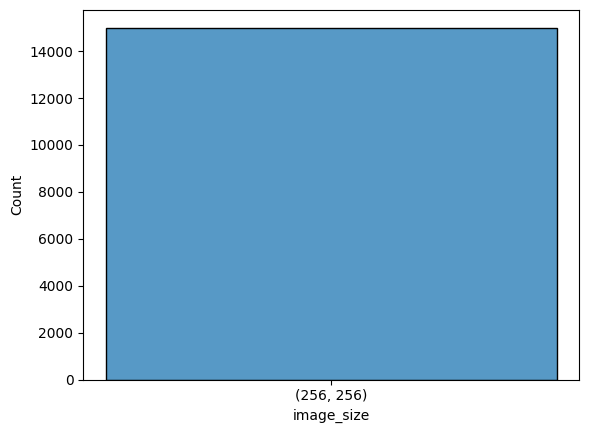

In [13]:
# What an interesting plot!
plottable_df = df.copy()
plottable_df['image_size'] = df['image_size'].astype('string')
print("Distribution of image sizes:")
sns.histplot(data=plottable_df, x ='image_size')
plt.show()

The following code counts the number of images per class and visualizes the results with a count plot:

Number of images per class:


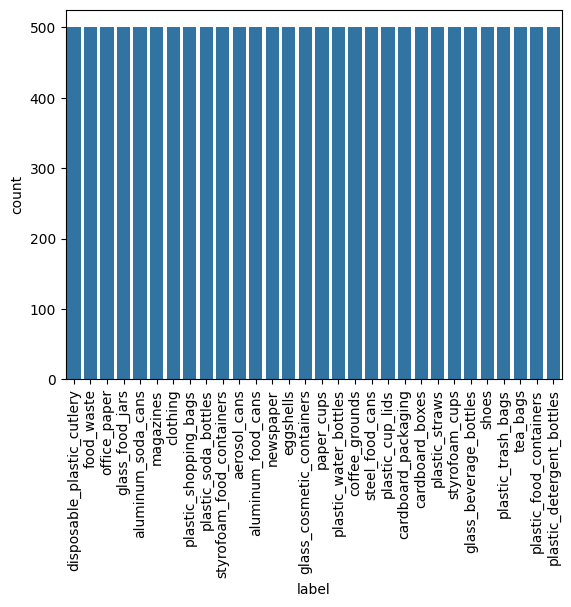

In [14]:
label_counts = plottable_df['label'].value_counts()
tiny_df = pd.DataFrame(label_counts)
print("Number of images per class:")
sns.countplot(data=plottable_df, x ='label')
plt.xticks(rotation=90)
plt.show()

The following block randomly selects one sample image from each class in the dataset and displays them in a grid format, showing the images alongside their respective labels:

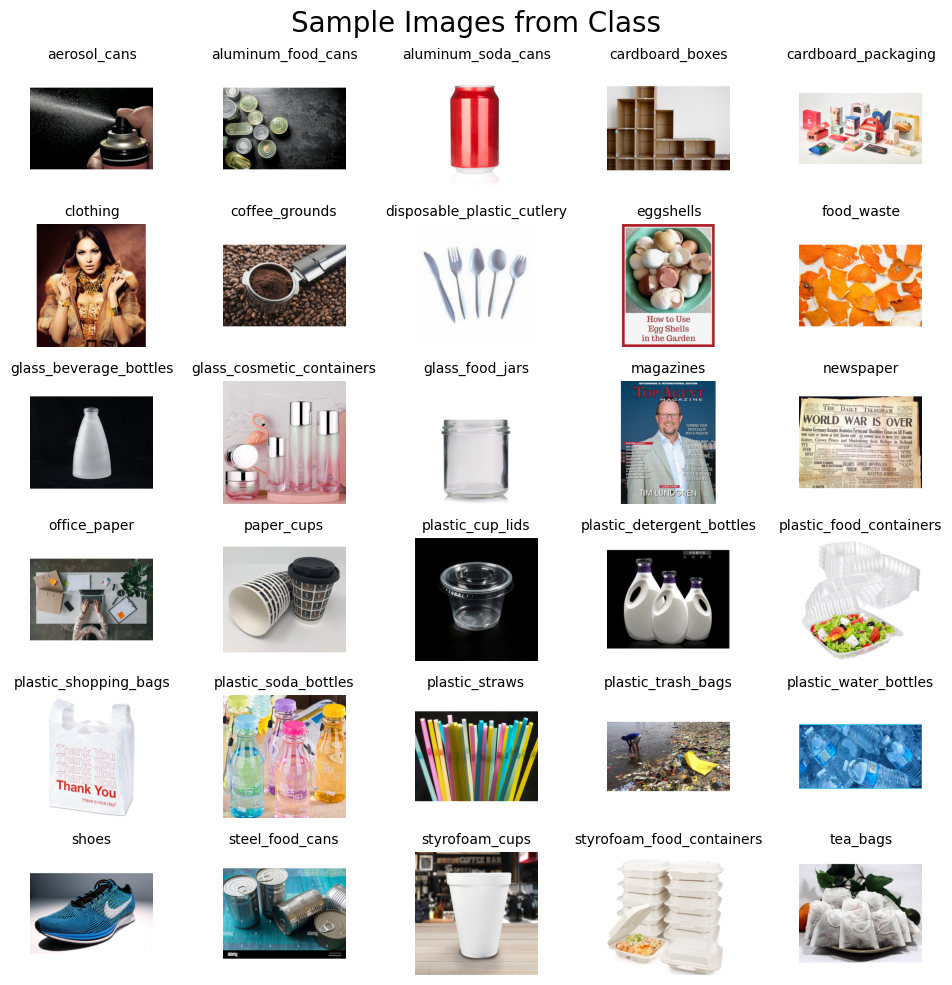

In [15]:
sample = df.groupby('label').sample(n=1).reset_index(drop=True)
num_samples = len(sample)

plt.figure(figsize=(10, 10))
plt.suptitle('Sample Images from Class', fontsize=20) 

for i in range(num_samples):
    img = Image.open(sample.iloc[i]['image_path']) 
    plt.subplot(6, 5, i + 1)
    plt.imshow(img)
    plt.title(sample.iloc[i]['label'], fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

Based on the data exploration conducted above, including the plot of image size distribution and the visualization of sample images, we observe that all images are of the same size (256x256). This uniformity eliminates the need for resizing or cropping to ensure consistent image dimensions. 

# Next Steps: More Data Preprocessing 

Our main goal is to classify waste items into three distinct categories: 

- **Landfill**: Items that are non-recyclable or non-compostable and should be disposed of in landfills. 
- **Recyclable**: Items that can be recycled, such as plastics, metals, glass, and paper products. 
- **Compost**: Items that can decompose and be used as compost.  

As a preprocessing step, we plan on combining the existing 30 waste categories into these broader categories. Additionally, we plan on creating a train test split using ONLY the default image data (comprised of studio images and stock photos of trash) for now. We will also apply min-max normalization to keep our image pixel data on a scale between 0 and 1. After normalizing, we will apply a filter to decrease noise in our images (we haven't yet decided on the best option yet, but it'll likely be either a gaussian or median filter).

| label | category/class |
|:------|:---------------|
| `'aerosol_cans'` | if empty recyclable, otherwise landfill |
| `'aluminum_food_cans'` | recyclable |
| `'aluminum_soda_cans'` | recyclable |
| `'cardboard_boxes'` | recyclable |
| `'cardboard_packaging'` | recyclable |
| `'clothing'` | landfill |
| `'coffee_grounds'` | compost |
| `'disposable_plastic_cutlery'` | landfill |
| `'eggshells'` | compost |
| `'food_waste'` | compost |
| `'glass_beverage_bottles'` | recyclable |
| `'glass_cosmetic_containers'` | recyclable |
| `'glass_food_jars'` | recyclable |
| `'magazines'` | recyclable |
| `'newspaper'` | recyclable |
| `'office_paper'` | recyclable |
| `'paper_cups'` | recyclable as long as not wax coated |
| `'plastic_cup_lids'` | recyclable? |
| `'plastic_detergent_bottles'` | recyclable |
| `'plastic_food_containers'` | recyclable |
| `'plastic_shopping_bags'` | landfill |
| `'plastic_soda_bottles'` | recyclable |
| `'plastic_straws'` | recyclable |
| `'plastic_trash_bags'` | landfill |
| `'plastic_water_bottles'` | recyclable |
| `'shoes'` | landfill |
| `'steel_food_cans'` | recyclable |
| `'styrofoam_cups'` | landfill |
| `'styrofoam_food_containers'` | landfill |
| `'tea_bags'` | compost if plastic free |

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7bcfc1ee-f9d0-4fbd-8938-ed6b0c0637f8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

In [16]:
clean_df = df.copy()
clean_df.label.unique()
cat_dic = {
    'landfill' : ['clothing', 'disposable_plastic_cutlery', 'plastic_shopping_bags', 'plastic_trash_bags',\
                  'shoes', 'styrofoam_cups', 'styrofoam_food_containers', 'paper_cups', 'plastic_straws', 'plastic_cup_lids'],
    'recyclable' : ['aerosol_cans','aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'cardboard_packaging', 'glass_beverage_bottles',\
                    'glass_cosmetic_containers', 'glass_food_jars', 'magazines', 'newspaper', 'office_paper', 'plastic_detergent_bottles',\
                    'plastic_food_containers','plastic_soda_bottles', 'plastic_water_bottles', 'steel_food_cans'],
    'compost' : ['coffee_grounds', 'eggshells', 'food_waste', 'tea_bags']
}

# Create a reverse lookup dictionary to map items to categories
item_to_category = {item: category for category, items in cat_dic.items() for item in items}

# Map the labels to respective categories using lookup dictionary
clean_df['category'] = df['label'].map(item_to_category)
clean_df.head()

image_path  \
0  /Users/lillianho/.cache/kagglehub/datasets/ali...   
1  /Users/lillianho/.cache/kagglehub/datasets/ali...   
2  /Users/lillianho/.cache/kagglehub/datasets/ali...   
3  /Users/lillianho/.cache/kagglehub/datasets/ali...   
4  /Users/lillianho/.cache/kagglehub/datasets/ali...   

                        label  image_size default_vs_real_world  category  
0  disposable_plastic_cutlery  (256, 256)               default  landfill  
1  disposable_plastic_cutlery  (256, 256)               default  landfill  
2  disposable_plastic_cutlery  (256, 256)               default  landfill  
3  disposable_plastic_cutlery  (256, 256)               default  landfill  
4  disposable_plastic_cutlery  (256, 256)               default  landfill

In [17]:
X = clean_df['image_path']
y = clean_df['category'] 

In [18]:
# 60/20/20 split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, shuffle=True)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)


In [19]:
# Finding the min and max pixel value in the training data
min_val = float('inf')
max_val = float('-inf')

for image_path in X_train:  
    image = Image.open(image_path)
    image_array = np.array(image)

    image_min = image_array.min()
    image_max = image_array.max()

    min_val = min(min_val, image_min)
    max_val = max(max_val, image_max)

print("Min Pixel Value:", min_val)
print("Max Pixel Value:", max_val)

Min Pixel Value: 0
Max Pixel Value: 255


In [20]:
def normalize_image(image_path):
    image = Image.open(image_path)
    image_array = np.array(image)

    # normalize with min-max scaling
    normalized_image = (image_array - min_val) / (max_val - min_val)
    return normalized_image

X_train_normalized = X_train.apply(normalize_image)
X_valid_normalized = X_valid.apply(normalize_image)
X_test_normalized = X_test.apply(normalize_image)

In [21]:
# Flatten each image to create 1D feature vectors
# X_train_flat = np.array([image.flatten() for image in X_train_normalized])
# X_test_flat = np.array([image.flatten() for image in X_test_normalized])

image_size = 256 * 256 * 3
X_train_flat = np.memmap('X_train_flat.dat', dtype='float32', mode='w+', shape=(len(X_train_normalized), image_size))
X_valid_flat = np.memmap('X_valid_flat.dat', dtype='float32', mode='w+', shape=(len(X_valid_normalized), image_size))
X_test_flat = np.memmap('X_test_flat.dat', dtype='float32', mode='w+', shape=(len(X_test_normalized), image_size))

# Fill in the memory-mapped arrays
for i, image in enumerate(X_train_normalized):
    X_train_flat[i] = image.flatten()
    
for i, image in enumerate(X_valid_normalized):
    X_valid_flat[i] = image.flatten()

for i, image in enumerate(X_test_normalized):
    X_test_flat[i] = image.flatten()

In [22]:
sample_image = X_train_normalized.iloc[1]
print("Normalized Image Shape:", sample_image.shape)
print("Pixel Value Range:", sample_image.min(), "to", sample_image.max(), "\n")

original_sample_image = np.array(Image.open(X_train.iloc[1]))
print("Normalized Image Shape:", original_sample_image.shape)
print("Pixel Value Range:", original_sample_image.min(), "to", original_sample_image.max())

Normalized Image Shape: (256, 256, 3)
Pixel Value Range: 0.0 to 1.0 

Normalized Image Shape: (256, 256, 3)
Pixel Value Range: 0 to 255


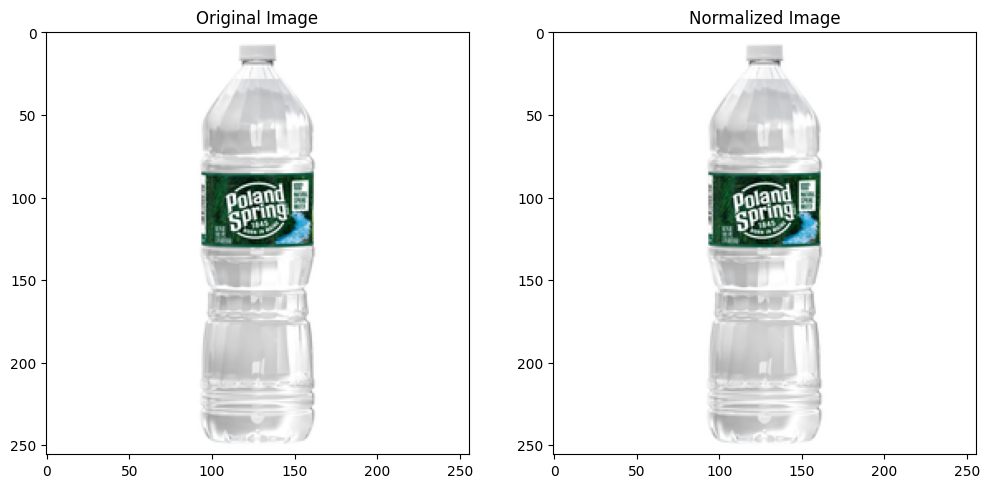

In [23]:
sample_image_path = X_train.iloc[1] 
original_image = Image.open(sample_image_path)
original_image = np.array(original_image)

normalized_image = X_train_normalized.iloc[1]
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")

# Normalized Image
plt.subplot(1, 2, 2)
plt.imshow(normalized_image)
plt.title("Normalized Image")

plt.show()

## Random Forest Classification

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [25]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train_flat, y_train)

RandomForestClassifier(random_state=42)

In [26]:
y_pred = rf_model.predict(X_test_flat)

In [27]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy}")

Accuracy on test set: 0.7756666666666666


In [28]:
y_train_pred = rf_model.predict(X_train_flat)

train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy: ", train_accuracy)

Training Accuracy:  0.9996666666666667


In [29]:
y_valid_pred = rf_model.predict(X_valid_flat)

valid_accuracy = accuracy_score(y_valid, y_valid_pred)
print("Validation Accuracy: ", valid_accuracy)

Validation Accuracy:  0.7983333333333333


Ground Truth and Predictions
Ground Truth and Predictions For Training Set
Ground Truth: recyclable
Prediction: recyclable
Ground Truth: recyclable
Prediction: recyclable
Ground Truth: landfill
Prediction: landfill
Ground Truth: recyclable
Prediction: recyclable
Ground Truth: recyclable
Prediction: recyclable
Ground Truth and Predictions For Validation Set
Ground Truth: compost
Prediction: compost
Ground Truth: recyclable
Prediction: recyclable
Ground Truth: recyclable
Prediction: recyclable
Ground Truth: compost
Prediction: compost
Ground Truth: landfill
Prediction: landfill
Ground Truth and Predictions For Testing Set
Ground Truth: landfill
Prediction: recyclable
Ground Truth: landfill
Prediction: recyclable
Ground Truth: landfill
Prediction: landfill
Ground Truth: landfill
Prediction: landfill
Ground Truth: recyclable
Prediction: recyclable


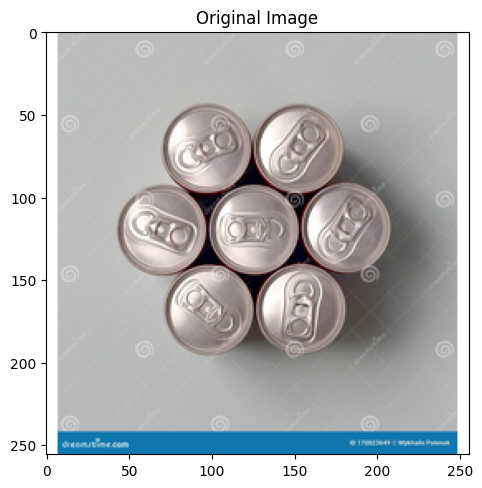

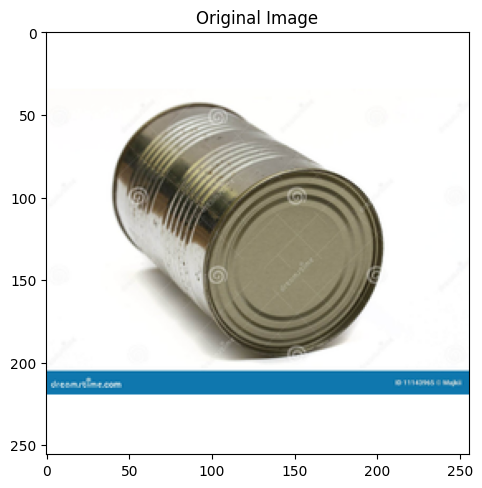

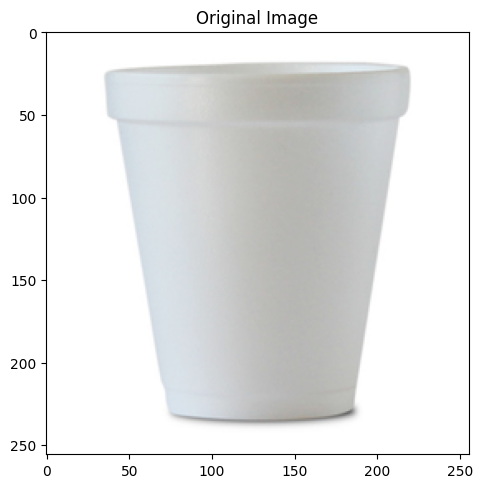

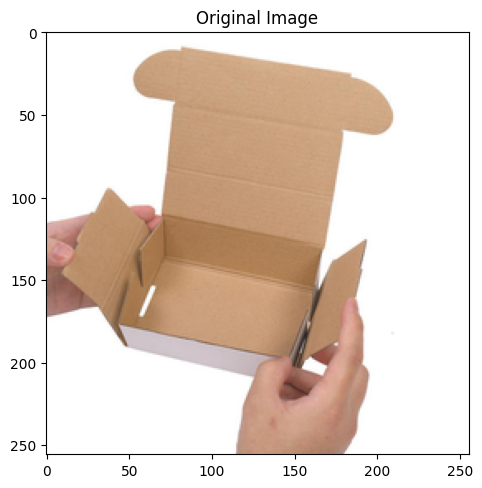

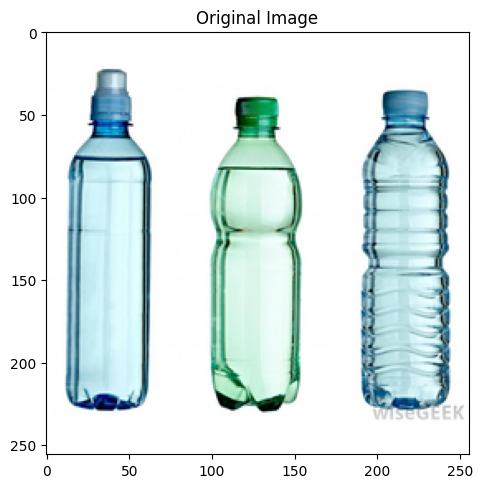

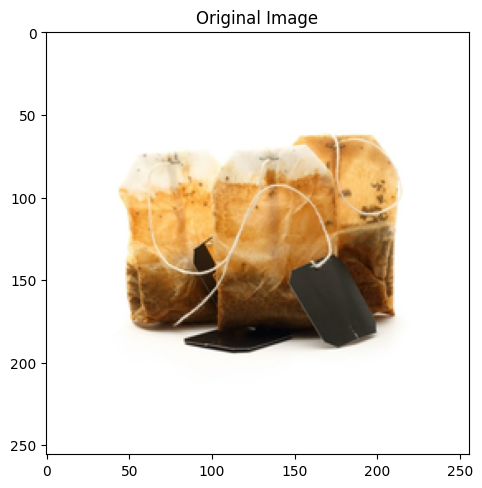

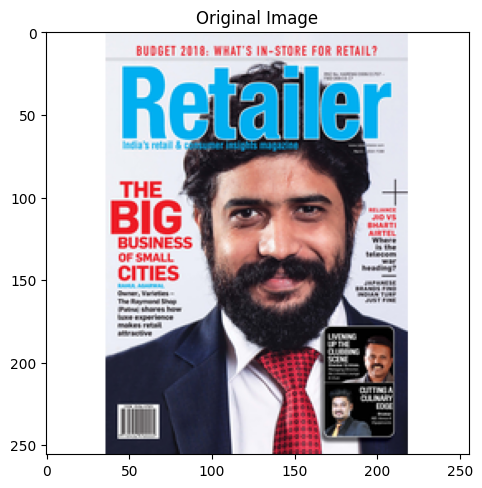

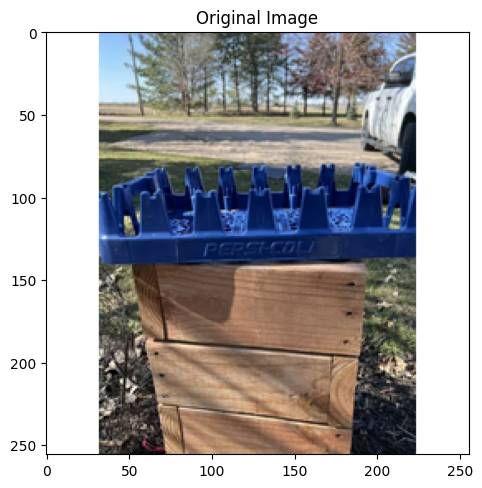

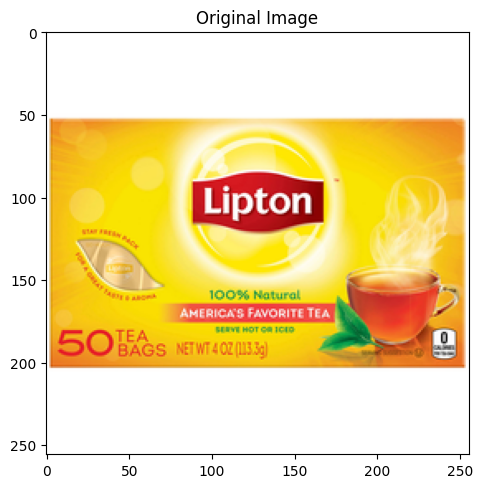

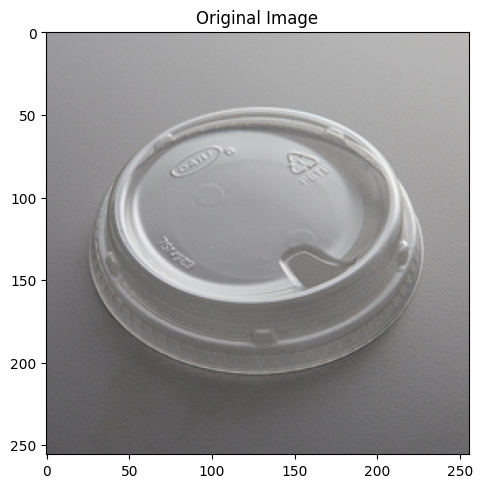

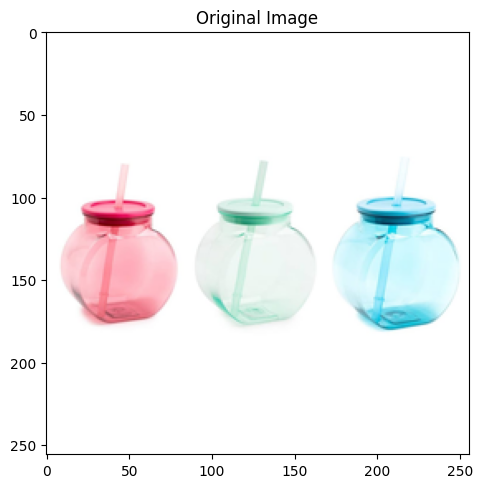

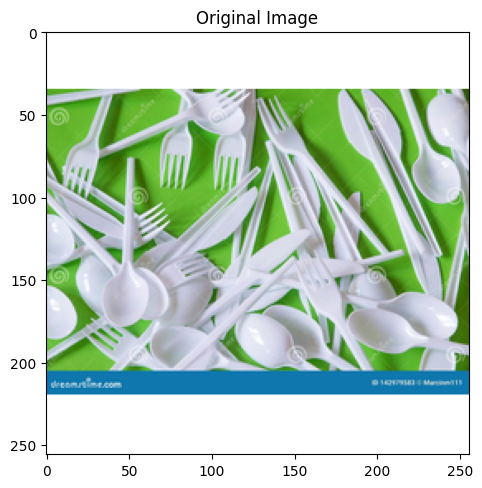

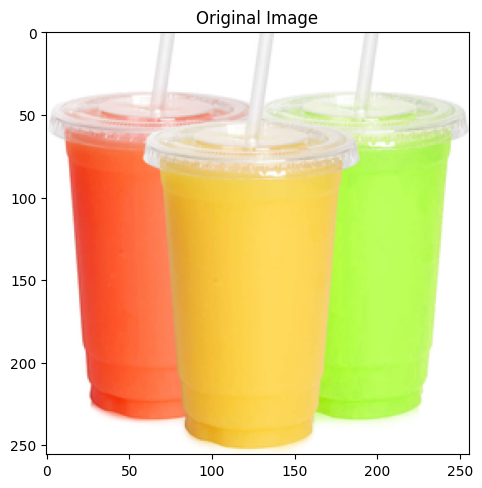

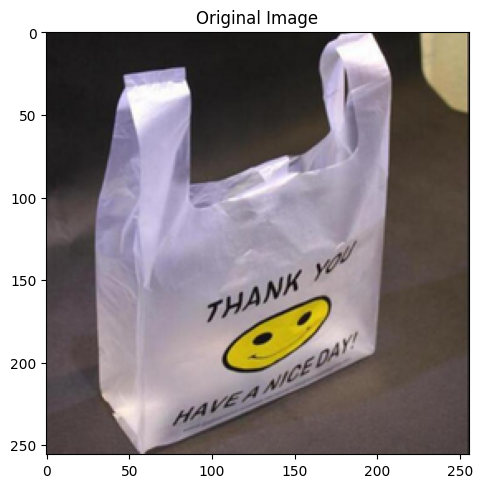

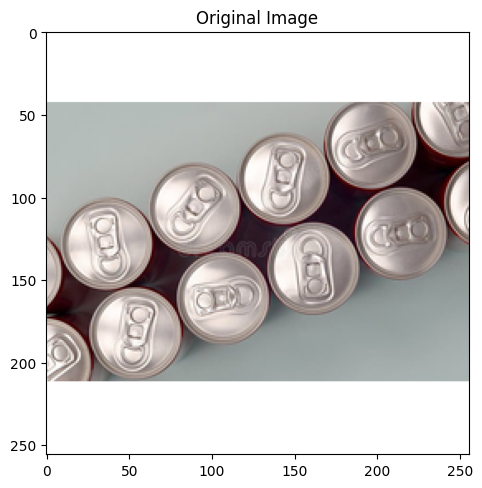

In [30]:
# example ground truth and predictions for train, validation and test
print("Ground Truth and Predictions")
print("Ground Truth and Predictions For Training Set")
length = len(y_train)
for i in range(0, length, int(length/5)):
  sample_image_path = X_train.iloc[i] 

  original_image = Image.open(sample_image_path)
  original_image = np.array(original_image)
  plt.figure(figsize=(12, 6))

  # Original Image
  plt.subplot(1, 2, 1)
  plt.imshow(original_image)
  plt.title("Original Image")
  print("Ground Truth:", y_train.iloc[i])
  print("Prediction:", y_train_pred[i])
  
print("Ground Truth and Predictions For Validation Set")
length = len(y_valid)
for i in range(0, length, int(length/5)):
  sample_image_path = X_valid.iloc[i] 

  original_image = Image.open(sample_image_path)
  original_image = np.array(original_image)
  plt.figure(figsize=(12, 6))

  # Original Image
  plt.subplot(1, 2, 1)
  plt.imshow(original_image)
  plt.title("Original Image")
  print("Ground Truth:", y_valid.iloc[i])
  print("Prediction:", y_valid_pred[i])

print("Ground Truth and Predictions For Testing Set")
length = len(y_pred)
for i in range(0, length, int(length/5)):
  sample_image_path = X_test.iloc[i] 

  original_image = Image.open(sample_image_path)
  original_image = np.array(original_image)
  plt.figure(figsize=(12, 6))

  # Original Image
  plt.subplot(1, 2, 1)
  plt.imshow(original_image)
  plt.title("Original Image")
  print("Ground Truth:", y_test.iloc[i])
  print("Prediction:", y_pred[i])

In [ ]:
def tune_rf_hyperparameters(X_train_flat, y_train, X_valid_flat, y_valid, X_test_flat, y_test):
    param_grid = {
        'n_estimators': [50, 60, 70, 80, 90, 100],
        'max_depth': [5, 10, 15],     
        'min_samples_split': [2, 5],
    }

    best_val_acc = 0
    best_params = None
    results = []

    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for min_samples_split in param_grid['min_samples_split']:
                
                rf_model = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    n_jobs=-1,
                    random_state=42
                )

                rf_model.fit(X_train_flat, y_train)

                train_acc = accuracy_score(y_train, rf_model.predict(X_train_flat))
                valid_acc = accuracy_score(y_valid, rf_model.predict(X_valid_flat))
                test_acc = accuracy_score(y_test, rf_model.predict(X_test_flat))

                print(f"Params: n_estimators={n_estimators}, max_depth={max_depth}, min_samples_split={min_samples_split} | "
                    f"Train Acc: {train_acc:.3f}, Valid Acc: {valid_acc:.3f}, Test Acc: {test_acc:.3f}")

                # Store results
                results.append({
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'train_acc': train_acc,
                    'valid_acc': valid_acc,
                    'test_acc': test_acc
                })

                if valid_acc > best_val_acc:
                    best_val_acc = valid_acc
                    best_params = {
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                    }

    print(f"\nBest Parameters: {best_params}, Best Validation Accuracy: {best_val_acc}")

    df = pd.DataFrame(results)
    return df, best_params


In [34]:
res_df, best_params = tune_rf_hyperparameters(X_train_flat, y_train, X_valid_flat, y_valid, X_test_flat, y_test)

Python(37024) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Params: n_estimators=50, max_depth=5, min_samples_split=2 | Train Acc: 0.636, Valid Acc: 0.627, Test Acc: 0.594
Params: n_estimators=50, max_depth=5, min_samples_split=5 | Train Acc: 0.635, Valid Acc: 0.625, Test Acc: 0.593
Params: n_estimators=50, max_depth=10, min_samples_split=2 | Train Acc: 0.923, Valid Acc: 0.768, Test Acc: 0.737
Params: n_estimators=50, max_depth=10, min_samples_split=5 | Train Acc: 0.921, Valid Acc: 0.760, Test Acc: 0.734
Params: n_estimators=50, max_depth=15, min_samples_split=2 | Train Acc: 0.988, Valid Acc: 0.787, Test Acc: 0.762
Params: n_estimators=50, max_depth=15, min_samples_split=5 | Train Acc: 0.987, Valid Acc: 0.787, Test Acc: 0.765
Params: n_estimators=60, max_depth=5, min_samples_split=2 | Train Acc: 0.638, Valid Acc: 0.628, Test Acc: 0.596
Params: n_estimators=60, max_depth=5, min_samples_split=5 | Train Acc: 0.638, Valid Acc: 0.629, Test Acc: 0.596
Params: n_estimators=60, max_depth=10, min_samples_split=2 | Train Acc: 0.924, Valid Acc: 0.763, Tes

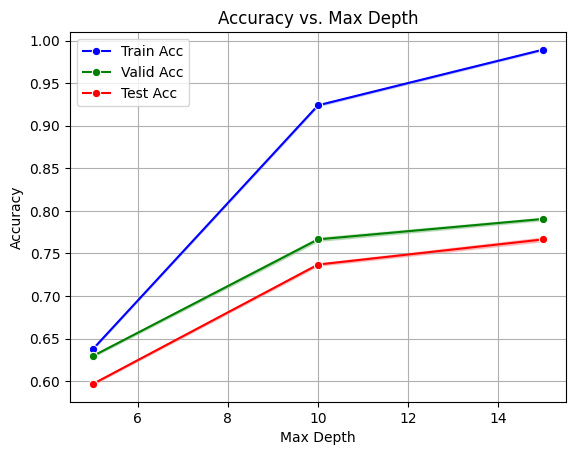

In [35]:
sns.lineplot(data=res_df, x='max_depth', y='train_acc', label='Train Acc', marker='o', linestyle='-', color='b')
sns.lineplot(data=res_df, x='max_depth', y='valid_acc', label='Valid Acc', marker='o', linestyle='-', color='g')
sns.lineplot(data=res_df, x='max_depth', y='test_acc', label='Test Acc', marker='o', linestyle='-', color='r')
plt.title('Accuracy vs. Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

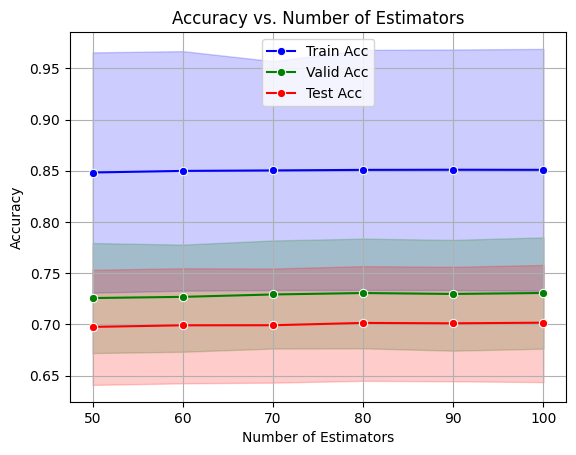

In [36]:
sns.lineplot(data=res_df, x='n_estimators', y='train_acc', label='Train Acc', marker='o', linestyle='-', color='b')
sns.lineplot(data=res_df, x='n_estimators', y='valid_acc', label='Valid Acc', marker='o', linestyle='-', color='g')
sns.lineplot(data=res_df, x='n_estimators', y='test_acc', label='Test Acc', marker='o', linestyle='-', color='r')

plt.title('Accuracy vs. Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

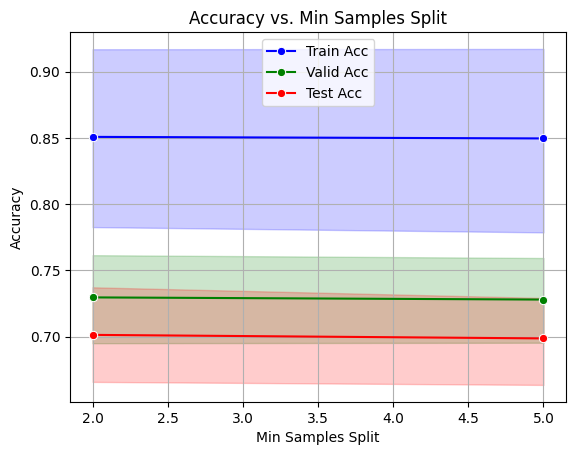

In [37]:
sns.lineplot(data=res_df, x='min_samples_split', y='train_acc', label='Train Acc', marker='o', linestyle='-', color='b')
sns.lineplot(data=res_df, x='min_samples_split', y='valid_acc', label='Valid Acc', marker='o', linestyle='-', color='g')
sns.lineplot(data=res_df, x='min_samples_split', y='test_acc', label='Test Acc', marker='o', linestyle='-', color='r')

plt.title('Accuracy vs. Min Samples Split')
plt.xlabel('Min Samples Split')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [85]:
res_df['train_valid_diff'] = abs(res_df['train_acc'] - res_df['valid_acc'])
res_df['valid_test_diff'] = abs(res_df['valid_acc'] - res_df['test_acc'])
res_df['train_test_diff'] = abs(res_df['train_acc'] - res_df['test_acc'])
threshold = 0.1

# Filter models that have low differences and good test accuracy
filtered_df = res_df[(res_df['train_valid_diff'] <= threshold) & (res_df['valid_test_diff'] <= threshold) & (res_df['train_test_diff'] <= threshold)]

sorted_filtered_df = filtered_df.sort_values(by='test_acc', ascending=False)
sorted_filtered_df

n_estimators  max_depth  min_samples_split  train_acc  valid_acc  \
19            80          5                  5   0.638111   0.630667   
25            90          5                  5   0.637667   0.629333   
13            70          5                  5   0.637889   0.630667   
12            70          5                  2   0.637333   0.631000   
24            90          5                  2   0.638333   0.629667   
18            80          5                  2   0.637556   0.631000   
31           100          5                  5   0.636444   0.630667   
7             60          5                  5   0.637889   0.629000   
6             60          5                  2   0.638222   0.628000   
30           100          5                  2   0.636111   0.630000   
0             50          5                  2   0.635667   0.627000   
1             50          5                  5   0.635444   0.624667   

    test_acc  train_valid_diff  valid_test_diff  train_test_diff  
19  0.599333          0.007444         0.031333         0.038778  
25  0.598667          0.008333         0.030667         0.039000  
13  0.597333          0.007222         0.033333         0.040556  
12  0.597000          0.006333         0.034000         0.040333  
24  0.597000          0.008667         0.032667         0.041333  
18  0.596667          0.006556         0.034333         0.040889  
31  0.596667          0.005778         0.034000         0.039778  
7   0.596333          0.008889         0.032667         0.041556  
6   0.596000          0.010222         0.032000         0.042222  
30  0.596000          0.006111         0.034000         0.040111  
0   0.593667          0.008667         0.033333         0.042000  
1   0.593333          0.010778         0.031333         0.042111

In [86]:
# Using parameters that achieved the highest test accuracy from the previous cell
improved_rf_model = RandomForestClassifier(n_estimators=80, max_depth=5, min_samples_split=5, n_jobs=-1)

improved_rf_model.fit(X_train_flat, y_train)

RandomForestClassifier(max_depth=5, min_samples_split=5, n_estimators=80,
                       n_jobs=-1)

In [87]:
improved_y_test_pred = improved_rf_model.predict(X_test_flat)

test_accuracy = accuracy_score(y_test, improved_y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.5966666666666667


In [88]:
improved_y_valid_pred = improved_rf_model.predict(X_valid_flat)

valid_accuracy = accuracy_score(y_valid, improved_y_valid_pred)
print(f"Valid Accuracy: {valid_accuracy}")

Valid Accuracy: 0.6363333333333333


In [89]:
improved_y_train_pred = improved_rf_model.predict(X_train_flat)

train_accuracy = accuracy_score(y_train, improved_y_train_pred)
print(f"Training Accuracy: {train_accuracy}")

Training Accuracy: 0.6441111111111111


In [90]:
rf_cm= confusion_matrix(y_test, improved_y_test_pred)

In [91]:
# CODE COPIED FROM SCI-KIT LEARN
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[  67   21  307]
 [  13  242  817]
 [  13   39 1481]]


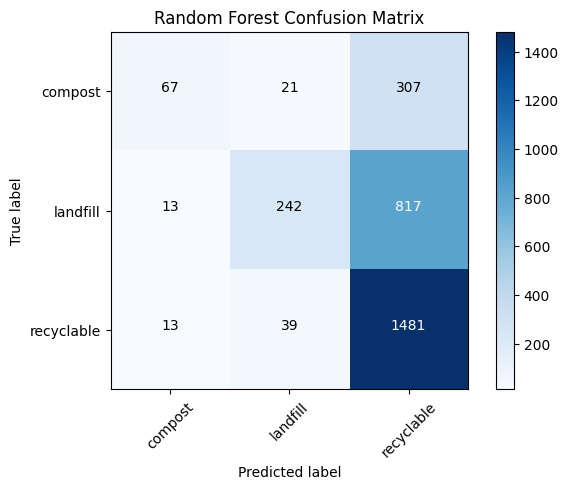

In [92]:
cm_plot_labels = ['compost', 'landfill', 'recyclable']
plot_confusion_matrix(cm=rf_cm, classes=cm_plot_labels, title='Random Forest Confusion Matrix')


In [93]:
accuracy = accuracy_score(y_test, improved_y_test_pred)
precision = precision_score(y_test, improved_y_test_pred, average='macro') 
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.5966666666666667
Precision: 0.6967588945916002
Recall: 0.7227903046304968
F1 Score: 0.7520317285770562


### Exploring HOG Features

In [50]:
def extract_hog_features(images):
    hog_features = []
    for image in images:
        image_gray = rgb2gray(image)
        
        features = hog(
            image_gray,
            orientations=9,        
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=False  
        )
        hog_features.append(features)
    
    return np.array(hog_features)

In [51]:
X_train_hog = extract_hog_features(X_train_normalized)
X_valid_hog= extract_hog_features(X_valid_normalized)
X_test_hog = extract_hog_features(X_test_normalized)

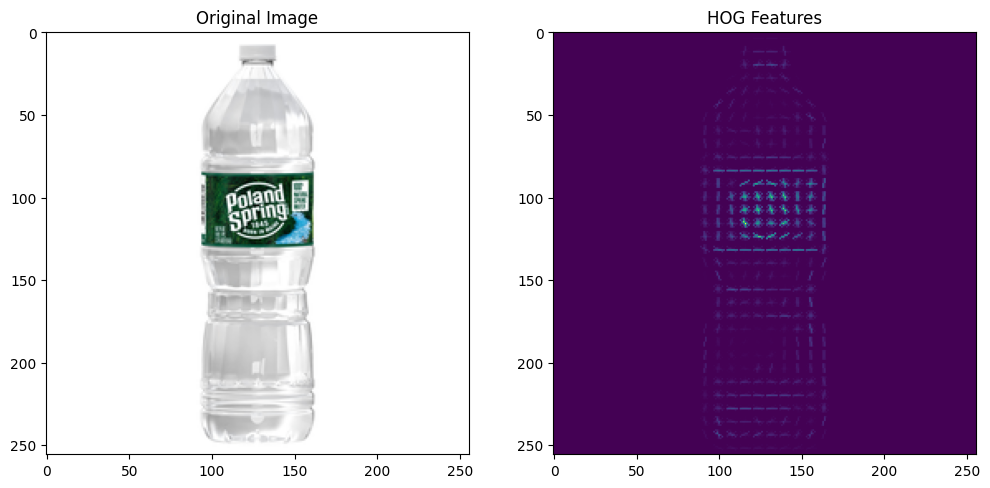

In [52]:
sample_image_path = X_train.iloc[1] 
original_image = Image.open(sample_image_path)
original_image = np.array(original_image)

sample_image_gray = rgb2gray(original_image)
        
features, hog_image = hog(
    sample_image_gray,
    orientations=9,        
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    visualize=True  
)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(hog_image)
plt.title("HOG Features")

plt.show()

In [53]:
hog_rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

hog_rf_model.fit(X_train_hog, y_train)

RandomForestClassifier(random_state=42)

In [54]:
y_test_pred = hog_rf_model.predict(X_test_hog)

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.7626666666666667


In [55]:
y_valid_pred = hog_rf_model.predict(X_valid_hog)

valid_accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"Valid Accuracy: {valid_accuracy}")

Valid Accuracy: 0.7696666666666667


In [56]:
y_train_pred = hog_rf_model.predict(X_train_hog)

train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy: ", train_accuracy)

Training Accuracy:  0.9996666666666667


In [57]:
# Tune hyperparameters to address overfitting
hog_res_df, best_hog_params = tune_rf_hyperparameters(X_train_hog, y_train, X_valid_hog, y_valid, X_test_hog, y_test)

Params: n_estimators=50, max_depth=5, min_samples_split=2 | Train Acc: 0.603, Valid Acc: 0.583, Test Acc: 0.559
Params: n_estimators=50, max_depth=5, min_samples_split=5 | Train Acc: 0.604, Valid Acc: 0.585, Test Acc: 0.559
Params: n_estimators=50, max_depth=10, min_samples_split=2 | Train Acc: 0.938, Valid Acc: 0.726, Test Acc: 0.713
Params: n_estimators=50, max_depth=10, min_samples_split=5 | Train Acc: 0.937, Valid Acc: 0.728, Test Acc: 0.716
Params: n_estimators=50, max_depth=15, min_samples_split=2 | Train Acc: 0.998, Valid Acc: 0.767, Test Acc: 0.745
Params: n_estimators=50, max_depth=15, min_samples_split=5 | Train Acc: 0.995, Valid Acc: 0.766, Test Acc: 0.746
Params: n_estimators=60, max_depth=5, min_samples_split=2 | Train Acc: 0.602, Valid Acc: 0.585, Test Acc: 0.559
Params: n_estimators=60, max_depth=5, min_samples_split=5 | Train Acc: 0.602, Valid Acc: 0.584, Test Acc: 0.559
Params: n_estimators=60, max_depth=10, min_samples_split=2 | Train Acc: 0.939, Valid Acc: 0.732, Tes

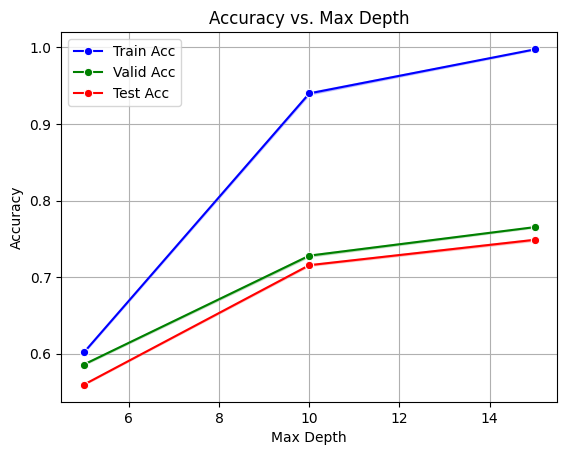

In [58]:
sns.lineplot(data=hog_res_df, x='max_depth', y='train_acc', label='Train Acc', marker='o', linestyle='-', color='b')
sns.lineplot(data=hog_res_df, x='max_depth', y='valid_acc', label='Valid Acc', marker='o', linestyle='-', color='g')
sns.lineplot(data=hog_res_df, x='max_depth', y='test_acc', label='Test Acc', marker='o', linestyle='-', color='r')
plt.title('Accuracy vs. Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

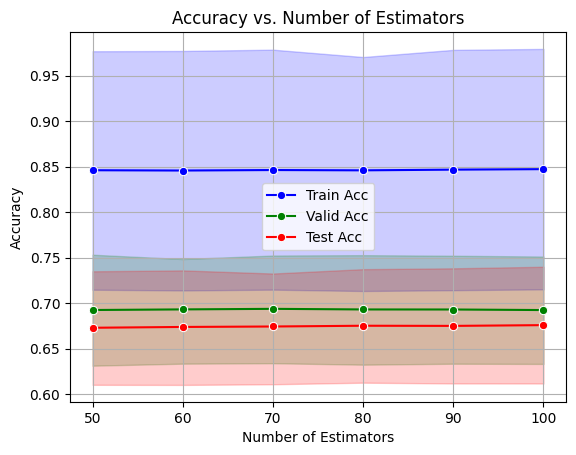

In [59]:
sns.lineplot(data=hog_res_df, x='n_estimators', y='train_acc', label='Train Acc', marker='o', linestyle='-', color='b')
sns.lineplot(data=hog_res_df, x='n_estimators', y='valid_acc', label='Valid Acc', marker='o', linestyle='-', color='g')
sns.lineplot(data=hog_res_df, x='n_estimators', y='test_acc', label='Test Acc', marker='o', linestyle='-', color='r')

plt.title('Accuracy vs. Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

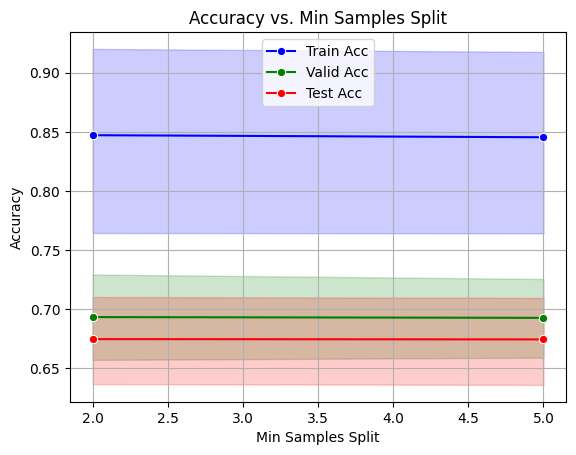

In [60]:
sns.lineplot(data=hog_res_df, x='min_samples_split', y='train_acc', label='Train Acc', marker='o', linestyle='-', color='b')
sns.lineplot(data=hog_res_df, x='min_samples_split', y='valid_acc', label='Valid Acc', marker='o', linestyle='-', color='g')
sns.lineplot(data=hog_res_df, x='min_samples_split', y='test_acc', label='Test Acc', marker='o', linestyle='-', color='r')

plt.title('Accuracy vs. Min Samples Split')
plt.xlabel('Min Samples Split')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [94]:
hog_res_df['train_valid_diff'] = abs(hog_res_df['train_acc'] - hog_res_df['valid_acc'])
hog_res_df['valid_test_diff'] = abs(hog_res_df['valid_acc'] - hog_res_df['test_acc'])
hog_res_df['train_test_diff'] = abs(hog_res_df['train_acc'] - hog_res_df['test_acc'])
threshold = 0.1

# Filter models that have low differences and good test accuracy
filtered_hog_df = hog_res_df[(hog_res_df['train_valid_diff'] <= threshold) & (hog_res_df['valid_test_diff'] <= threshold) & (hog_res_df['train_test_diff'] <= threshold)]

sorted_filtered_hog_df = filtered_hog_df.sort_values(by='test_acc', ascending=False)
sorted_filtered_hog_df

n_estimators  max_depth  min_samples_split  train_acc  valid_acc  \
18            80          5                  2   0.600111   0.585667   
19            80          5                  5   0.600444   0.586000   
25            90          5                  5   0.600556   0.586333   
30           100          5                  2   0.601222   0.586667   
24            90          5                  2   0.600222   0.585000   
12            70          5                  2   0.601111   0.587333   
6             60          5                  2   0.601778   0.585000   
7             60          5                  5   0.602222   0.584333   
31           100          5                  5   0.602000   0.586333   
1             50          5                  5   0.603889   0.585333   
0             50          5                  2   0.603333   0.583000   
13            70          5                  5   0.601111   0.588333   

    test_acc  train_valid_diff  valid_test_diff  train_test_diff  
18  0.560667          0.014444         0.025000         0.039444  
19  0.560667          0.014444         0.025333         0.039778  
25  0.559667          0.014222         0.026667         0.040889  
30  0.559667          0.014556         0.027000         0.041556  
24  0.559333          0.015222         0.025667         0.040889  
12  0.559333          0.013778         0.028000         0.041778  
6   0.559333          0.016778         0.025667         0.042444  
7   0.559333          0.017889         0.025000         0.042889  
31  0.559333          0.015667         0.027000         0.042667  
1   0.559000          0.018556         0.026333         0.044889  
0   0.559000          0.020333         0.024000         0.044333  
13  0.558333          0.012778         0.030000         0.042778

In [69]:
improved_hog_rf_model = RandomForestClassifier(n_estimators=80, max_depth=5, min_samples_split=2, n_jobs=-1)

improved_hog_rf_model.fit(X_train_hog, y_train)

RandomForestClassifier(max_depth=5, n_estimators=80, n_jobs=-1)

In [70]:
improved_hog_y_test_pred = improved_hog_rf_model.predict(X_test_hog)

test_accuracy = accuracy_score(y_test, improved_hog_y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.5596666666666666


In [71]:
improved_hog_y_valid_pred = improved_hog_rf_model.predict(X_valid_hog)

valid_accuracy = accuracy_score(y_valid, improved_hog_y_valid_pred)
print(f"Valid Accuracy: {valid_accuracy}")

Valid Accuracy: 0.586


In [72]:
improved_hog_y_train_pred = improved_hog_rf_model.predict(X_train_hog)

train_accuracy = accuracy_score(y_train, improved_hog_y_train_pred)
print(f"Training Accuracy: {train_accuracy}")

Training Accuracy: 0.6037777777777777


In [73]:
rf_hog_cm= confusion_matrix(y_test, improved_hog_y_test_pred)

Confusion matrix, without normalization
[[   0   16  379]
 [   0  166  906]
 [   0   20 1513]]


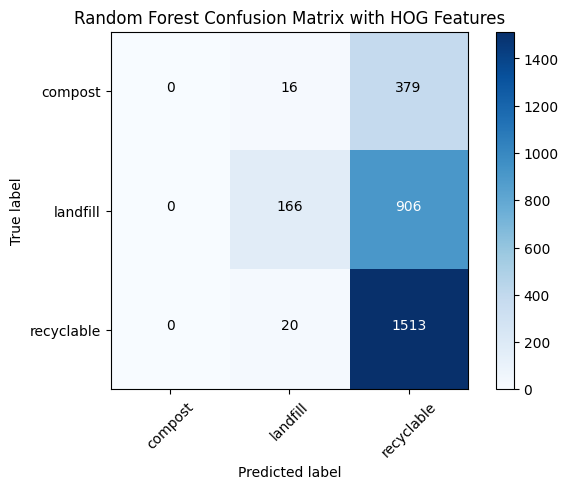

In [74]:
plot_confusion_matrix(cm=rf_hog_cm, classes=cm_plot_labels, title='Random Forest Confusion Matrix with HOG Features')